<a href="https://colab.research.google.com/github/dimandms/motor_temperatures/blob/refactoring/Motors_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goals of the Notebook are:

1. Prepare EDA, understand main features, prepare new features
2. Try to solve bussness cases:

- Estimate current temperature of windings base on measures of currents, voltages, speed, torque and coolant to understand possibility of operations
- Forecast temperatures of windings to understand if the state will be unappropriate

3. Build real-time web application with simulation

https://www.researchgate.net/publication/331976678_Empirical_Evaluation_of_Exponentially_Weighted_Moving_Averages_for_Simple_Linear_Thermal_Modeling_of_Permanent_Magnet_Synchronous_Machines

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from typing import List, Dict, Callable
from enum import Enum

In [3]:
from itertools import product

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.linear_model import RidgeCV
from sklearn.metrics import SCORERS, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/pmsm_temperature_data.csv')

In [6]:
df.head(5)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4.0
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4.0
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4.0
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4.0
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4.0


In [7]:
df.tail(5)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
447033,1.213597,-0.136662,-1.338092,0.315069,1.256531,0.545459,-1.252652,0.463151,0.511155,0.194606,0.420417,0.521998,53.0
447034,1.191186,-0.140209,-1.369103,0.238541,1.241300,0.571222,-1.306237,0.484911,0.513488,0.194769,0.421996,0.525975,53.0
447035,0.385230,-0.240271,-1.423605,0.053742,1.231921,0.614536,-1.443613,0.518100,0.517571,0.194886,0.423170,0.526255,53.0
447036,0.613102,-0.211967,-1.476665,-0.156781,1.235651,0.666284,-1.602808,0.546530,0.520731,0.194969,0.423589,0.526151,53.0
447037,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df[df.isna().any(axis=1)]

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
447037,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.dropna(inplace=True)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,447037.0,-0.545941,1.066580,-8.573954,-1.135694,-0.391432,0.297613,2.967117
coolant,447037.0,-0.490912,0.860188,-1.429349,-1.070198,-1.042651,-0.100206,2.271667
u_d,447037.0,-0.312512,0.928724,-1.655373,-1.115274,-0.329154,0.297833,2.274734
u_q,447037.0,0.106391,0.903787,-1.861463,-0.702505,0.006741,0.846473,1.793366
motor_speed,447037.0,0.130303,0.985389,-1.371529,-0.689896,-0.077112,0.941943,2.024164
torque,447037.0,0.324993,0.934409,-3.276957,-0.254833,0.341525,0.845668,3.016971
i_d,447037.0,-0.137845,1.052223,-3.245874,-0.987611,0.038149,0.924246,1.060937
i_q,447037.0,0.328384,0.930032,-3.276311,-0.245712,0.308788,0.820970,2.914185
pm,447037.0,-0.188450,1.110109,-2.631991,-1.027167,-0.156329,0.594209,2.917456
stator_yoke,447037.0,-0.386383,0.934120,-1.834688,-1.095658,-0.480506,0.216848,2.393537


As we see with description, all features scaled. profile_id is just the id of running

### Data exploration
Note 1: Profile_id is corresponde to single experiment. Rows of dataframe represent samples and are sorted by time. Sample values is measured within 0.5 seconds (2 Hz)

Note 2: Target features are tempretures (pm, stator_yoke, stator_tooth, stator_winding)

Questions are:

1. Interesting to know duration of profiles.
2. Find correlations in features
3. Look at time series charts and possible anomalies in it
4. Try to find time series behavior and interconnection
5. Try to find noise in data

In [11]:
MEASURES_IN_SECOND = 2
SECONDS_IN_HOUR = 3600

PLOT_STYLE = "darkgrid"
PLOT_PRIMARY_COLOR = "#333333"

TEMPERATURE_FUTURES = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

In [12]:
def plot_profile_durations(df: pd.DataFrame):
    grouped_df = df.groupby('profile_id').size().rename('samples').reset_index()
    
    with sns.axes_style(PLOT_STYLE):
        _, ax = plt.subplots(1, 1, figsize=(17,5))

        HOURS_MIN=0
        HOURS_MAX=8
        hours_ticks: np.ndarray = np.arange(1, HOURS_MAX)

        sns.barplot(y='samples', x='profile_id', data=grouped_df, color=PLOT_PRIMARY_COLOR, ax=ax)
        
        ax.set_yticks(MEASURES_IN_SECOND*SECONDS_IN_HOUR*hours_ticks)
        ax.set_yticklabels([f'{h}' for h in hours_ticks])
        ax.set_ylim((HOURS_MIN*MEASURES_IN_SECOND*SECONDS_IN_HOUR, (HOURS_MAX-1)*MEASURES_IN_SECOND*SECONDS_IN_HOUR))
        ax.set_ylabel('duration, hours')        

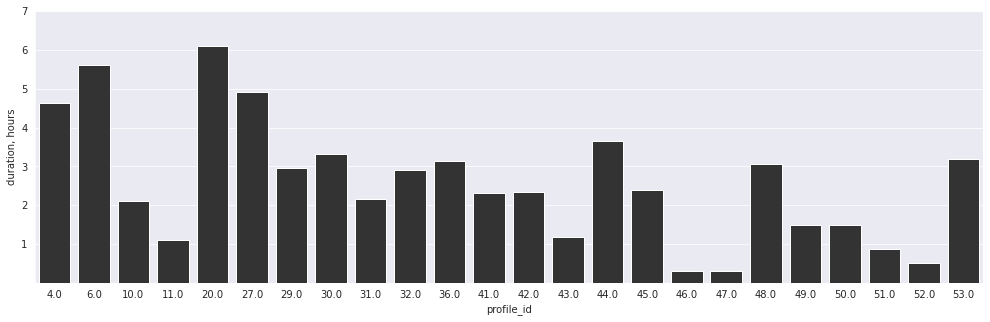

In [13]:
plot_profile_durations(df)

### Conclutions
Here we see that some experiments were very short (about 20 minutes) and potentially they have not any interesting data. Some were long and should have insights in data. Let's look at time series charts of target features

In [14]:
def plot_experiment_time_series(df: pd.DataFrame, profile_id: int, num_of_points=None, features=[]):
    if num_of_points is None:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()
    else:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()[0:num_of_points]

    with sns.axes_style(PLOT_STYLE):
        _, axes = plt.subplots(len(features), 1, figsize=(15, len(features)*2), sharex=True)
        for ax, feature_name in zip(axes, features):
            ax.plot(filtered_df[feature_name], color=PLOT_PRIMARY_COLOR)
            ax.set_ylabel(feature_name)

In [15]:
def plot_experiment_time_series_single_grid(df: pd.DataFrame, profile_id: int, num_of_points=None, features=[]):
    if num_of_points is None:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()
    else:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()[0:num_of_points]

    with sns.axes_style(PLOT_STYLE):
        _, ax = plt.subplots(1, 1, figsize=(15, 2))
        ax.plot(filtered_df[features[0]], color=PLOT_PRIMARY_COLOR, label=features[0])
        ax.plot(filtered_df[features[1]], color="#cc9602", label=features[1])
        ax.legend()

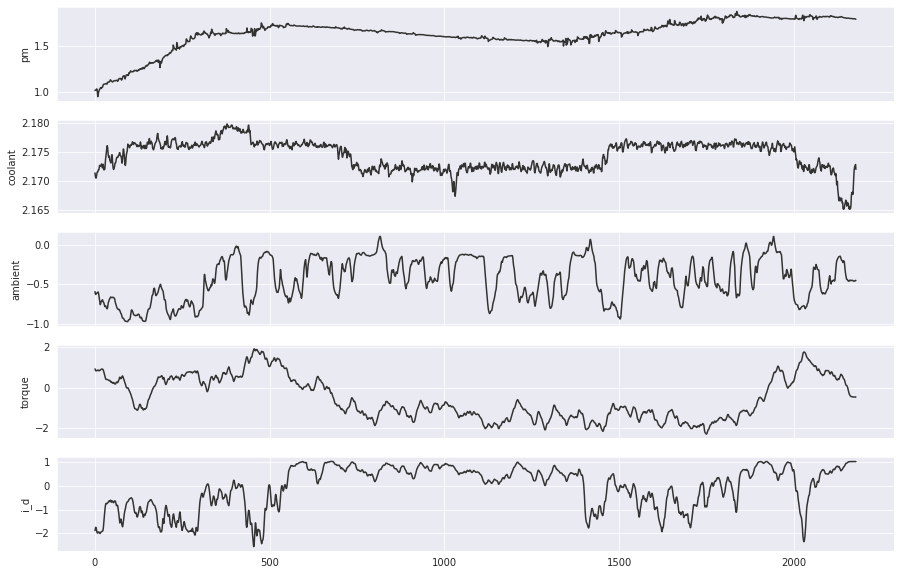

In [16]:
#short experiment
plot_experiment_time_series(df, 46, features = ['pm','coolant','ambient', 'torque', 'i_d'])

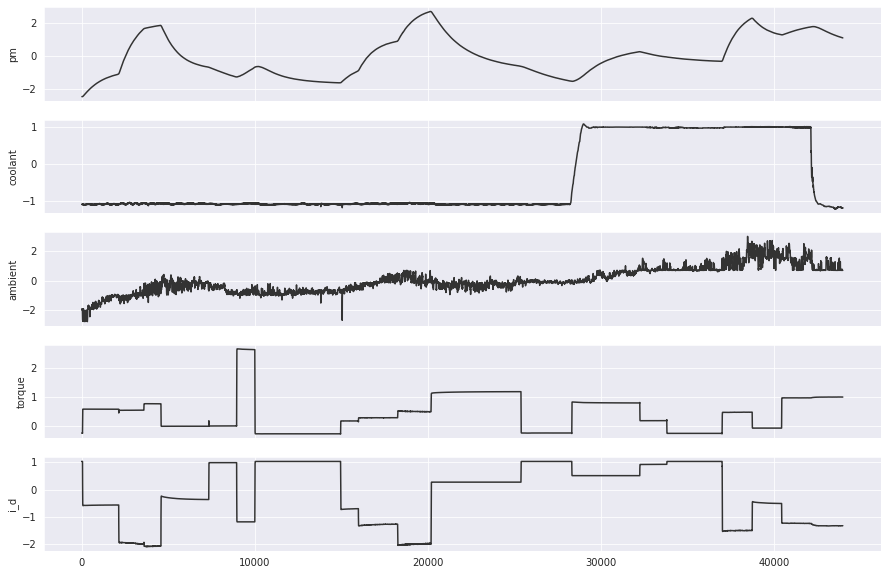

In [17]:
#long experiment
plot_experiment_time_series(df, 20, features=['pm','coolant','ambient', 'torque', 'i_d'])

So, as we see short runnings of motor do not nave any insights of process.

Long term runnings have more interesting process changes. Temperature of stator and rotor exponentially grows/decay after step change of the parameters. But we do not saw any strict dependency in load -> grows or unload -> decay. Maybe it is because of lack of the stator current magnitude (here we could know about Joule–Lenz law: Q ~ I**2, where Q is heat and I is current magnitude)

Also ambient temperature values are noizy, though we need to eliminate that noise with smothing

In [18]:
def calculate_magnitude(value_d: float, value_q: float) -> float:
    return np.sqrt(value_d**2 + value_q**2)

def generate_current_feature(df: pd.DataFrame) -> pd.Series:
    current_magnitude = calculate_magnitude(df['i_d'], df['i_q'])
    return current_magnitude

def generate_voltage_feature(df: pd.DataFrame) -> pd.Series:
    voltage_magnitude = calculate_magnitude(df['u_d'], df['u_q'])
    return voltage_magnitude

def generate_apparent_power_feature(df: pd.DataFrame) -> pd.Series:
    apparent_power = df['current'] * df['voltage']
    return apparent_power

def generate_active_power_feature(df: pd.DataFrame) -> pd.Series:
    active_power = df['i_d'] * df['u_d'] + df['i_q'] * df['u_q']
    return active_power

def generate_reactive_power_feature(df: pd.DataFrame) -> pd.Series:
    reactive_power = df['u_q'] * df['i_d'] - df['u_d'] * df['i_q']
    return reactive_power

In [19]:
df = df.assign(**{
    "current": generate_current_feature,
    "voltage": generate_voltage_feature,
    "apparent_power": generate_apparent_power_feature,
    "active_power": generate_active_power_feature,
    "reactive_power": generate_reactive_power_feature
})

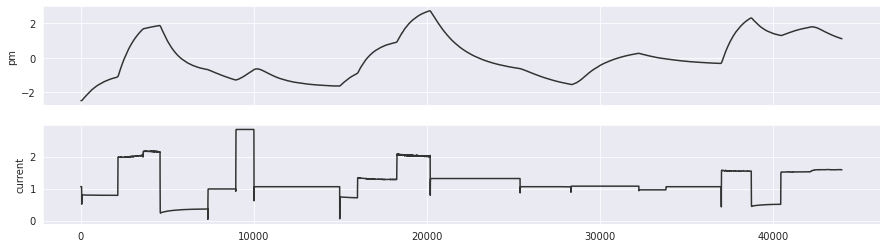

In [20]:
plot_experiment_time_series(df, 20, features=['pm','current'])

Now it is clear that steps in current magnitude produce exponential changes in temperatures

Let's smooth abmient values with moving avarage to prevent unstabale learning process and validation. To understand number of samples to aggragete in MA algorithm we can plot short part of profile 

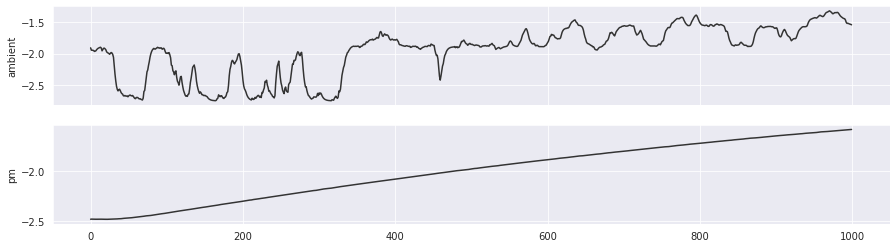

In [21]:
plot_experiment_time_series(df.reset_index(), 20,  num_of_points=1000, features=['ambient', 'pm'])

In [22]:
def generate_smoothed_feature(feature_name: str, window=500) -> pd.Series:
  def generate(df: pd.DataFrame):
    return (df.groupby('profile_id')[feature_name]
                           .rolling(window, 1)
                           .mean()
                           .dropna()
                           .reset_index(drop=True))
  return generate

In [23]:
df_ma_smooth_expample = df.assign(smoothed_ambient = generate_smoothed_feature('ambient'), 
               smoothed_coolant = generate_smoothed_feature('coolant', 100))

Let's check if our smooting is work right

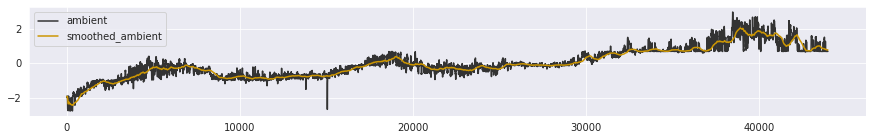

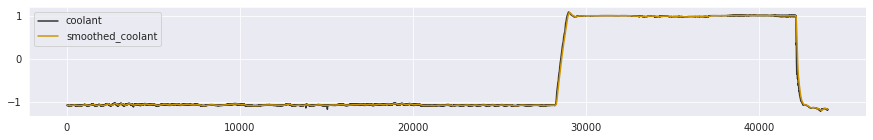

In [24]:
plot_experiment_time_series_single_grid(df_ma_smooth_expample.reset_index(), 
                                        20, 
                                        features=['ambient', 'smoothed_ambient'])
plot_experiment_time_series_single_grid(df_ma_smooth_expample.reset_index(), 
                                        20, 
                                        features=['coolant', 'smoothed_coolant'])

### Exponential features

As we saw above, we need to know history of parameters to estimate temperature. So we could generate exponential smoothing of current magnitude.

In [56]:
def exponential_weighted_smoothing(series: pd.Series, span: int):
  return (series.transform(lambda x: x.ewm(span, min_periods=1).mean())
                .reset_index(drop=True))

In [46]:
def generate_exponentially_smoothed_feature(feature_name: str, span: int) -> pd.Series:
  def generate(df: pd.DataFrame):
    return (df.groupby('profile_id')[feature_name]
                           .transform(lambda x: x.ewm(span, min_periods=1).mean())
                           .reset_index(drop=True))
  return generate


def define_exponentially_smoothed_features(features: List[str], spans: List[int]) -> Dict[str, Callable]:
  return {f"{feature}_ewma_{span}": generate_exponentially_smoothed_feature(feature, span) for feature, span in product(features, spans)}

In [26]:
smoothed_df_ex = df.assign(**define_exponentially_smoothed_features(['current', 'motor_speed'], 
                                                                    [500, 1000, 3000, 5000, 9000]))
smoothed_df_ex.columns

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding',
       'profile_id', 'current', 'voltage', 'apparent_power', 'active_power',
       'reactive_power', 'current_ewma_500', 'current_ewma_1000',
       'current_ewma_3000', 'current_ewma_5000', 'current_ewma_9000',
       'motor_speed_ewma_500', 'motor_speed_ewma_1000',
       'motor_speed_ewma_3000', 'motor_speed_ewma_5000',
       'motor_speed_ewma_9000'],
      dtype='object')

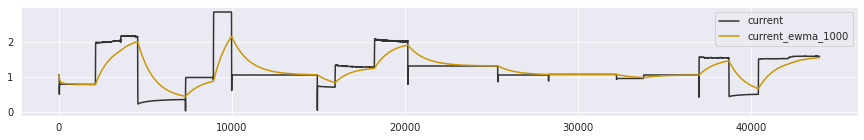

In [27]:
plot_experiment_time_series_single_grid(smoothed_df_ex.reset_index(), 20, features=['current', 'current_ewma_1000'])

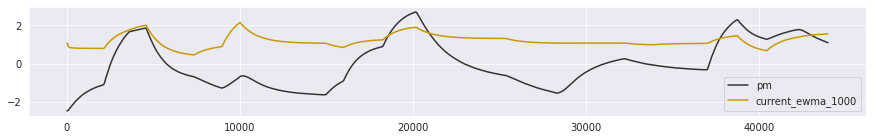

In [28]:
plot_experiment_time_series_single_grid(smoothed_df_ex.reset_index(), 20, features=['pm', 'current_ewma_1000'])

In [42]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

In [75]:
def _groupby(df: pd.DataFrame, column: str):
  return df.groupby(column)

In [77]:
def _exponential_weighted_smoothing(series: pd.Series, span: int):
  return (series.transform(lambda x: x.ewm(span, min_periods=1).mean())
                .reset_index(drop=True))

In [ ]:
#pipeline should be like this

pipe = make_pipeline(
  FunctionTransformer(_groupby, kw_args={"column": "profile_id"}),
  EwmaTransformer(features=["current", "coolant"], spans=[1300, 2500, 3600], drop_transformed=True),
  Drop("profile_id"),
  Ridge(alpha=0.01, scoring=make_scorer(mean_squared_error))
)

GridSearchCV(pipe, cv=5, paraps={"ewmatransformer__features": [["current", "current"]]})

pipe.fit(X_train)

In [29]:
# change span for current -> see validation curve -> has optimal span?
# change nubmer of spans -> see validation curve -> has optimal number of spans?
# change alphas (RidgeCV) -> best alpha for model
# plot predictions and calc metric on each profile

Let's prepare helper to eveluate our experiments with models

In [30]:
class EsimationModes(Enum):
  RANGE_SPANS = 1
  CUMULATIVE_SPAN = 2

In [31]:
# rewrite with https://scikit-learn.org/stable/developers/develop.html

def eval_with_ewma(X, y, conf, scoring='neg_mean_squared_error', cv=5, test_size=0.3, random_seed=42):
  train_scores = []
  test_scores = []
  trained_estimators = []
  ewma_feature_conf = []

  if conf["mode"] == EsimationModes.RANGE_SPANS:
    for span in conf["ewma_span_range"]:
      _X = X.assign(**define_exponentially_smoothed_features(conf["ewma_features"], [span]))
      X_train, X_test, y_train, y_test = train_test_split(_X.drop("profile_id", axis=1), y, test_size=test_size, random_state=random_seed)

      best_model = RidgeCV(conf["alphas"], fit_intercept=False, scoring=scoring, cv=cv).fit(X_train, y_train)

      scorer = SCORERS[scoring]
      train_score = scorer(best_model, X_train, y_train)
      test_score = scorer(best_model, X_test, y_test)

      train_scores.append(train_score)
      test_scores.append(test_score)
      trained_estimators.append(best_model)
      ewma_feature_conf.append([span])

  elif conf["mode"] == EsimationModes.CUMULATIVE_SPAN:
    for idx in range(len(conf["ewma_span_range"])):
      spans = conf["ewma_span_range"][:idx]

      _X = X.assign(**define_exponentially_smoothed_features(conf["ewma_features"], spans))
      X_train, X_test, y_train, y_test = train_test_split(_X.drop("profile_id", axis=1), y, test_size=test_size, random_state=random_seed)

      best_model = RidgeCV(conf["alphas"], fit_intercept=False, scoring=scoring, cv=cv).fit(X_train, y_train)

      scorer = SCORERS[scoring]
      train_score = scorer(best_model, X_train, y_train)
      test_score = scorer(best_model, X_test, y_test)

      train_scores.append(train_score)
      test_scores.append(test_score)
      trained_estimators.append(best_model)
      ewma_feature_conf.append(spans)
   
  return train_scores, test_scores, trained_estimators, ewma_feature_conf

In [32]:
def plot_train_test_curves(train_score, test_score, conf, scoring):
  if conf["mode"] == EsimationModes.RANGE_SPANS:
    x_plot = conf["ewma_span_range"]
    title = "span range"
    xlabel = "span"
  elif conf["mode"] == EsimationModes.CUMULATIVE_SPAN:
    x_plot = range(1, len(conf["ewma_span_range"])+1)
    title = "span numbers"
    xlabel = "span numbers"

  with sns.axes_style(PLOT_STYLE):
      _, ax = plt.subplots(1, 1, figsize=(10, 5))
      ax.plot(x_plot, train_score, color=PLOT_PRIMARY_COLOR, label="train score")
      ax.plot(x_plot, test_score, color="#cc9602", label="test score")
      ax.legend()
      ax.set_ylabel(scoring)
      ax.set_xlabel(xlabel)  
      ax.set_title(title)

In [33]:
df.columns

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding',
       'profile_id', 'current', 'voltage', 'apparent_power', 'active_power',
       'reactive_power'],
      dtype='object')

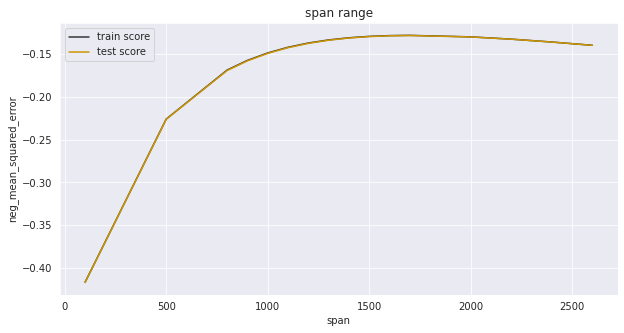

In [34]:
conf = {
    "ewma_features": ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d',
       'i_q', 'current', 'voltage', 'apparent_power', 'active_power', 'reactive_power'], 
    "ewma_span_range": [100,500,800,900,1000,1100,1200,1300,1400,1500,1600,1700,2000,2200,2400,2600],
    "alphas": np.logspace(-3, 3, num=7, base=10),
    "mode": EsimationModes.RANGE_SPANS
}

X = df.drop(TEMPERATURE_FUTURES+["torque"], axis=1)
y = df["pm"]

train_score, test_score, trained_estimators, feature_confs = eval_with_ewma(X, y, conf)
plot_train_test_curves(train_score, test_score, conf, 'neg_mean_squared_error')

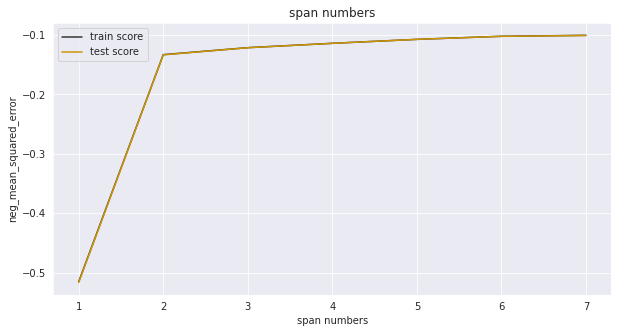

In [35]:
conf = {
    "ewma_features": ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d',
       'i_q', 'current', 'voltage', 'apparent_power', 'active_power', 'reactive_power'], 
    "ewma_span_range": [1300,2000,3000,4000,5000,6000,7000],
    "alphas": np.logspace(-3, 3, num=7, base=10),
    "mode": EsimationModes.CUMULATIVE_SPAN
}

X = df.drop(TEMPERATURE_FUTURES + ["torque"], axis=1) # use smoothed instead
y = df["pm"]

train_score, test_score, trained_estimators, feature_confs = eval_with_ewma(X, y, conf)
plot_train_test_curves(train_score, test_score, conf, 'neg_mean_squared_error')

In [36]:
def plot_fitted_values(df, estimator, conf, profile_ids_plot=None):
  profile_ids = df.profile_id.unique() if profile_ids_plot is None else profile_ids_plot

  _df = df.assign(**define_exponentially_smoothed_features(conf["ewma_features"],
                                                           conf["ewma_span_range"]))
  with sns.axes_style(PLOT_STYLE):
      _, axes = plt.subplots(len(profile_ids), 
                             1, 
                             figsize=(15, len(profile_ids)*2))
      
      for ax, profile_id in zip(axes, profile_ids):
        _df_profile = _df[_df.profile_id == profile_id]
        y_pred = estimator.predict(_df_profile.drop(TEMPERATURE_FUTURES + ["profile_id", "torque"], axis=1))
        y_true = _df_profile["pm"].values
        ax.plot(y_true, color=PLOT_PRIMARY_COLOR)
        ax.plot(y_pred, color="#cc9602")
        ax.set_ylabel(f"pm: pid {profile_id}")

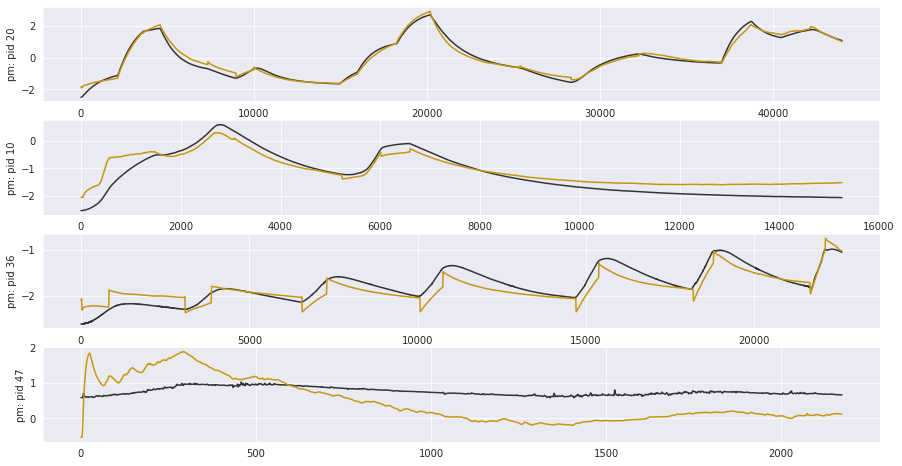

In [37]:
conf = {
    "ewma_features": ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d',
       'i_q', 'current', 'voltage', 'apparent_power', 'active_power', 'reactive_power'], 
    "ewma_span_range": feature_confs[6],
}

plot_fitted_values(df, trained_estimators[6], conf, [20,10,36,47])

### Concluton on Ridge

1. Long runnings predited very well. It's is because of step load/unload
2. Due to exponential smoothing in our futures, prediction accuracy good after some time since start
3. Due to p.2, short runnings prediction is uwful
4. In long runnings we can see some weak predictons
5. Error distributed not normally

### Ways to improve

1. More complex model
2. Future selection (some not needed)
3. Different loss function / metric

In [ ]:
import xgboost as xgb

In [ ]:

def eval_with_ewma(X, y, conf, scoring='neg_mean_squared_error', cv=5, test_size=0.3, random_seed=42):
  train_scores = []
  test_scores = []
  trained_estimators = []
  ewma_feature_conf = []

  if conf["mode"] == EsimationModes.RANGE_SPANS:
    for span in conf["ewma_span_range"]:
      _X = X.assign(**define_exponentially_smoothed_features(conf["ewma_features"], [span]))
      X_train, X_test, y_train, y_test = train_test_split(_X.drop("profile_id", axis=1), y, test_size=test_size, random_state=random_seed)

      best_model = xgb.XGBRegressor().fit(X_train, y_train)

      scorer = SCORERS[scoring]
      train_score = scorer(best_model, X_train, y_train)
      test_score = scorer(best_model, X_test, y_test)

      train_scores.append(train_score)
      test_scores.append(test_score)
      trained_estimators.append(best_model)
      ewma_feature_conf.append([span])

  elif conf["mode"] == EsimationModes.CUMULATIVE_SPAN:
    for idx in range(len(conf["ewma_span_range"])):
      spans = conf["ewma_span_range"][:idx]

      _X = X.assign(**define_exponentially_smoothed_features(conf["ewma_features"], spans))
      X_train, X_test, y_train, y_test = train_test_split(_X.drop("profile_id", axis=1), y, test_size=test_size, random_state=random_seed)

      best_model = xgb.XGBRegressor().fit(X_train, y_train)

      scorer = SCORERS[scoring]
      train_score = scorer(best_model, X_train, y_train)
      test_score = scorer(best_model, X_test, y_test)

      train_scores.append(train_score)
      test_scores.append(test_score)
      trained_estimators.append(best_model)
      ewma_feature_conf.append(spans)
   
  return train_scores, test_scores, trained_estimators, ewma_feature_conf

[20:05:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


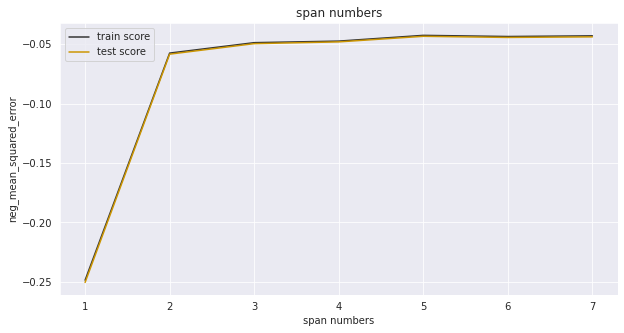

In [ ]:
conf = {
    "ewma_features": ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d',
       'i_q', 'current', 'voltage', 'apparent_power', 'active_power', 'reactive_power'], 
    "ewma_span_range": [1300,2000,3000,4000,5000,6000,7000],
    "mode": EsimationModes.CUMULATIVE_SPAN
}

X = df.drop(TEMPERATURE_FUTURES + ["torque"], axis=1) # use smoothed instead
y = df["pm"]

train_score, test_score, trained_estimators, feature_confs = eval_with_ewma(X, y, conf)
plot_train_test_curves(train_score, test_score, conf, 'neg_mean_squared_error')

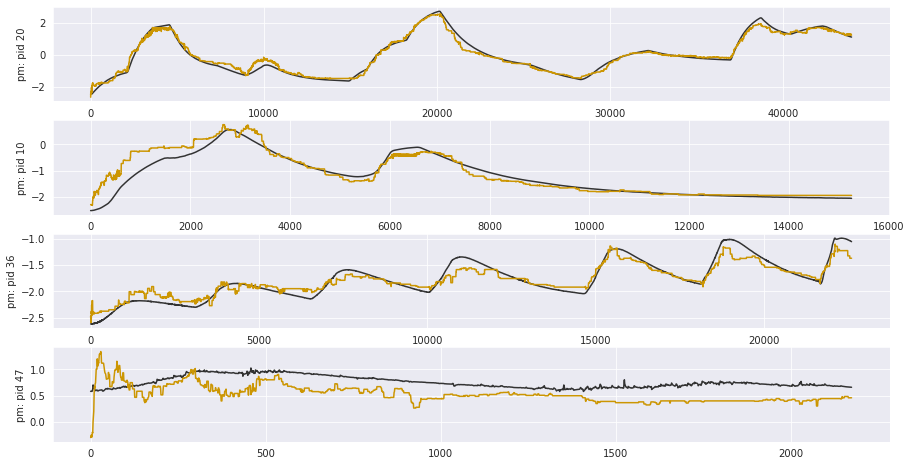

In [ ]:
conf = {
    "ewma_features": ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d',
       'i_q', 'current', 'voltage', 'apparent_power', 'active_power', 'reactive_power'], 
    "ewma_span_range": feature_confs[6],
}

plot_fitted_values(df, trained_estimators[6], conf, [20,10,36,47])

In [ ]:
def generate_signal_lag(series: pd.Series, lag_number: int) -> Dict[str, pd.Series]:
    return {f'{series.name}_lag_{lag_number}': series.shift(lag_number)}


def generate_signal_lags(series: pd.Series, lag_numbers: List[int]) -> Dict[str, pd.Series]:
    result = {}
    for lag in lag_numbers:
        result.update(generate_signal_lag(series, lag))
    
    return result


def generate_lags_for_profile(profile_df: pd.DataFrame, features: List[str], lag_numbers: List[int]) -> Dict[str, pd.Series]:
    result = {}
    
    for feature in profile_df[features]:
        lags_values = generate_signal_lags(profile_df[feature], lag_numbers)
        result.update(lags_values)
    
    return result

def add_lags(df: pd.DataFrame, features: List[str], lag_numbers: List[int]):
    result = []
    
    for profile_id in df.profile_id.unique():
        profile_df = df[df.profile_id==profile_id]
        lags_data = generate_lags_for_profile(profile_df, features, lag_numbers)
        new_profile_df = profile_df.assign(**lags_data)
        result.append(new_profile_df)
        
    return pd.concat(result).dropna()

In [ ]:
#complete_df = add_lags(df, ['current','ambient','coolant'], np.linspace(120, 1200, 10, dtype=int))

In [ ]:
dfx = pd.DataFrame({'A':['x1','x1','x1','x1','x1','x2','x2','x2','x2','x2'],'B': [0, 1, 2, 3, 4,10, 11, 12, 13, 14]})

In [ ]:
dfx

,A,B
0,x1,0
1,x1,1
2,x1,2
3,x1,3
4,x1,4
5,x2,10
6,x2,11
7,x2,12
8,x2,13
9,x2,14


In [ ]:
dfx.groupby('A').rolling(3, 1).mean().reset_index(drop=True)

,B
0,0.0
1,0.5
2,1.0
3,2.0
4,3.0
5,10.0
6,10.5
7,11.0
8,12.0
9,13.0


In [ ]:
dfx.rolling(3, 1).mean()

,B
0,0.0
1,0.5
2,1.0
3,2.0
4,3.0
